In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


In [77]:
# read calendar seattle
df_cal_s = pd.read_csv('./calendar_seattle.csv')

# clean price values
df_cal_tonum_s = df_cal_s['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_cal_tonum_s = pd.to_numeric(df_cal_tonum, errors='coerce')
print('Seattle')
print("average price: ",df_cal_tonum_s.mean())
print("occupancy rate (False: sold): ", df_cal_s['price'].isna().value_counts() / len(df_cal_s['price']) * 100)

# read calendar boston
df_cal_b = pd.read_csv('./calendar_boston.csv')

# clean 2017 data to make it comparable to seattle
#df_cal_2016 = df_cal_b[~df_cal_b.date.str.contains("2017")]
#df_cal_b = df_cal_2016

# clean price values
df_cal_tonum_b = df_cal_b['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_cal_tonum_b = pd.to_numeric(df_cal_tonum_b, errors='coerce')
print('Boston')
print("average price: ",df_cal_tonum.mean())
print("occupancy rate (False: sold): ", df_cal_b['price'].isna().value_counts() / len(df_cal_b['price']) * 100)




Seattle
average price:  209.95969781245236
occupancy rate (False: sold):  False    67.061002
True     32.938998
Name: price, dtype: float64
Boston
average price:  209.95969781245236
occupancy rate (False: sold):  True     50.871578
False    49.128422
Name: price, dtype: float64


   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


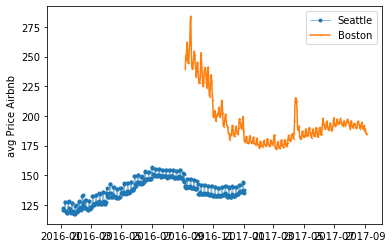

In [116]:
print(df_cal_s.head())
df_b_date_price = df_cal_b[['date','price']]
df_b_date_price = df_b_date_price.dropna(subset=['price'], axis=0)
df_b_date_price['price'] = df_b_date_price['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_b_date_price['price'] = pd.to_numeric(df_b_date_price['price'], errors='coerce')
#print(df_b_date_price.head())
#print(df_s_date_price)
df_b_date_price['date'] = pd.to_datetime(df_b_date_price[['date']].squeeze())
df_b_date_price = df_b_date_price.set_index('date')
#print(df_s_date_price.loc['2016-01-04'].mean())
#print(df_s_date_price.groupby('date').mean())

df_s_date_price = df_cal_s[['date','price']]
df_s_date_price = df_s_date_price.dropna(subset=['price'], axis=0)
df_s_date_price['price'] = df_s_date_price['price'].replace({'\$':''}, regex = True).dropna().squeeze()
df_s_date_price['price'] = pd.to_numeric(df_s_date_price['price'], errors='coerce')
df_s_date_price['date'] = pd.to_datetime(df_s_date_price[['date']].squeeze())
df_s_date_price = df_s_date_price.set_index('date')
#print(df_s_date_price)
#print(df_s_date_price.loc['2016-01-04'].mean())
#print(df_s_date_price.groupby('date').mean())





# Start and end of the date range to extract
start, end = '2014-01', '2023-01'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()

ax.plot(df_s_date_price.loc[start:end, 'price'].groupby('date').mean(), marker='.', linestyle='-', linewidth=0.5, label='Seattle')
ax.plot(df_b_date_price.loc[start:end, 'price'].groupby('date').mean(), marker='.', linestyle='-', markersize=1, label='Boston')

ax.set_ylabel('avg Price Airbnb')
ax.legend()

In [117]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [45]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)
        
    #Split into explanatory and response variables
    X = df.drop(columns=[response_col], axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [46]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

test_score, train_score:  0.5167556323913027 0.5553330385785233
                           est_int     coefs  abs_coefs
6                        longitude  0.411494   0.411494
21          review_scores_accuracy  0.195601   0.195601
5                         latitude -0.140339   0.140339
24     review_scores_communication  0.118131   0.118131
25          review_scores_location  0.112746   0.112746
20            review_scores_rating  0.050670   0.050670
22       review_scores_cleanliness  0.050461   0.050461
9                         bedrooms  0.046518   0.046518
7                     accommodates -0.043908   0.043908
10                            beds  0.038667   0.038667
23           review_scores_checkin -0.019518   0.019518
16                 availability_60  0.007010   0.007010
8                        bathrooms -0.005097   0.005097
26  calculated_host_listings_count -0.005088   0.005088
15                 availability_30 -0.004624   0.004624
17                 availability_90 -0.00

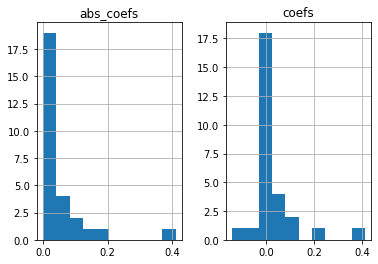

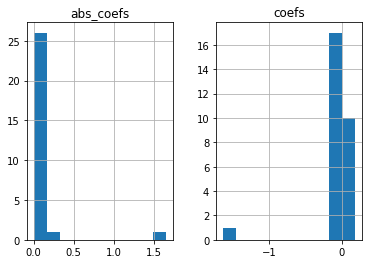

In [56]:
#Read in linstings data and store in a list
df_lis_s = pd.read_csv('./listings_seattle.csv')
df_lis_b = pd.read_csv('./listings_boston.csv')
df_lists = [df_lis_s, df_lis_b]

# Loop for seattle and boston
for df_lis in df_lists:
    
    # Filter for categorical variables
    df_new = df_lis.select_dtypes(include=[np.number])
    cat_cols_lst = df_new.select_dtypes(include=['object']).columns

    #Value of interest:
    response_col = 'review_scores_value'
    
    #Clean and fit linear model
    test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_new, 'review_scores_value', cat_cols_lst, dummy_na=False)
    print("test_score, train_score: ", test_score, train_score)

    #Calc the coef weights
    coef_df = coef_weights(lm_model.coef_, X_train)

    #Show the 20 most significant influencing variables
    review_scores = ['review_scores_location','review_scores_rating','review_scores_cleanliness','review_scores_checkin', 'review_scores_accuracy','review_scores_communication']
    print(coef_df.head(20))
    coef_df.hist()